In [22]:
import sys
sys.path.append('..')
import queueing_process.queueing_process as qp
import matplotlib.pyplot as plt
import imageio
import scipy.stats as ss
import seaborn as sns
import numpy as np
import numpy.random as npr
sns.set()

# Delay distributions

We consider two delay distributions:
 
1. There is a delay between symptom onset and joining the queue
2. There is a delay for the lab to process the result once the test has been taken

In [23]:
def symptom_onset_to_joining_queue():
    return round(npr.gamma(
        shape=2.62**2/2.38**2,
        scale=2.38**2/2.62))

Text(0.5, 1.0, 'Symptom onset to attempting to get a test (1000 samples)')

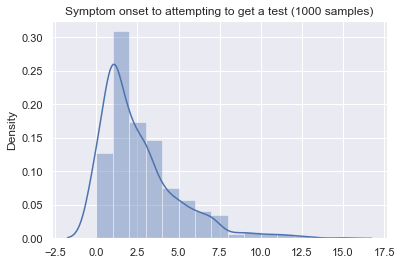

In [24]:
x = [symptom_onset_to_joining_queue() for i in range(1000)]
sns.distplot(x, bins = int(max(x) - min(x)))
plt.title('Symptom onset to attempting to get a test (1000 samples)')

In [25]:
def test_processing_delay_dist():
    return round(ss.gamma.rvs(a=4.941424, scale=0.266155))

Text(0.5, 1.0, 'Test processing delay distribution (1000 samples)')

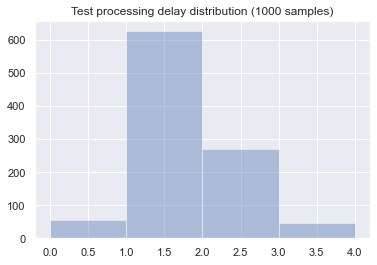

In [26]:
x = [test_processing_delay_dist() for i in range(1000)]
sns.distplot(x, bins = int(max(x) - min(x)), kde = False)
plt.title('Test processing delay distribution (1000 samples)')

# Model set up

* We simulate 50 days of the queuing process
* Let $I(t)$ be the number of total infections on day $t$, then we set $I(t) = I(0)\exp(rt)$ where $r = 0.07$
* The initial number of infections, $I(0) = 10000$
* The demand on day $t$ is set equal to the incidence on day $t$, as such given by $I(t) - I(t-1) = I(t) - \exp(-r)I(t) = I(t)(1-\exp(-r))$

In [27]:
# Epidemic incidence (equates to demand)
days_to_simulate = 50
growth_rate = 0.07
starting_infections = 10000
proportion_of_cases_asking_for_a_test = 0.2
def incidence(time):
    incidence_out = proportion_of_cases_asking_for_a_test*starting_infections*(np.exp(growth_rate*time) - np.exp(growth_rate*(time-1)))
    return int(round(incidence_out))
demand = [incidence(time) for time in range(days_to_simulate)] 

# Testing capacity
initial_capacity = 500
daily_capacity_increase = 0
capacity = [initial_capacity + daily_capacity_increase * time for time in range(days_to_simulate)]

In [28]:
%%time
my_queue = qp.queueing_process(
    days_to_simulate = days_to_simulate,
    capacity = capacity,
    demand = demand,
    symptom_onset_to_joining_queue_dist = symptom_onset_to_joining_queue,
    test_processing_delay_dist = test_processing_delay_dist
)

Wall time: 249 ms


The chunk runs the model

In [29]:
%%time
my_queue.run_simulation(verbose = True)

Wall time: 1.75 s


In [ ]:
capacity_hitting_time = np.array(range(0, days_to_simulate))[np.array(demand) > np.array(capacity)].min()

plt.plot('time','capacity', data = my_queue.queue_info)
#plt.plot('time','capacity_exceeded_by', data = my_queue.queue_info)
plt.plot('time','spillover_to_next_day', data = my_queue.queue_info)
plt.plot('time','number_left_queue_not_tested', data = my_queue.queue_info)
plt.plot('time','new_applicants', data = my_queue.queue_info)
plt.title('Queueing process summary statistics')
plt.xlabel('Time of joining queue (days)')
plt.legend(['Capacity',
            #'Amount capacity exceeded by',
            'Spillover to next day',
            'Number left queue not tested',
            'New applicants',
            'hitting time'])
plt.xlim(0, days_to_simulate - 10)
plt.ylim(-50, 8000)
plt.vlines(x = capacity_hitting_time, ymin = 0, ymax = 8000, linestyle = '--', alpha = 0.7)
plt.savefig('../Figures/QueueingProcess.png')

In [ ]:
plt.plot([my_queue.get_prob_getting_tested(time) for time in range(days_to_simulate - 10)])
plt.title('Probability of successfully getting tested')
plt.xlabel('Time of joining queue (days)')
plt.ylabel('$P$(getting tested)')
plt.ylim(0,1.1)
plt.vlines(x = capacity_hitting_time, ymin = 0, ymax = 1, linestyle = '--', alpha = 0.7)
plt.savefig('../Figures/ProbabilityGettingTested.png')

## Over varying growth rates

We vary the growth rates to demonstrate the reduced capacity hitting times, and faster exponential decay of TTI capability once that capacity is reached.

In [32]:
growth_rates = [0.03, 0.04, 0.05, 0.06, 0.07]

# Model parameters
days_to_simulate = 120
growth_rate = 0.07
starting_infections = 10000
proportion_of_cases_asking_for_a_test = 0.3

# demand function
def new_demand(time, growth_rate):
    incidence_out = proportion_of_cases_asking_for_a_test*starting_infections*(np.exp(growth_rate*time) - np.exp(growth_rate*(time-1)))
    return int(round(incidence_out))

# Testing capacity
initial_capacity = 500
daily_capacity_increase = 0
capacity = [initial_capacity + daily_capacity_increase * time for time in range(days_to_simulate)]

for rate in growth_rates:
    demand_over_time = [new_demand(time, growth_rate = rate) for time in range(days_to_simulate)] 

    my_queue = qp.queueing_process(
        days_to_simulate = days_to_simulate,
        capacity = capacity,
        demand = demand_over_time,
        symptom_onset_to_joining_queue_dist = symptom_onset_to_joining_queue,
        test_processing_delay_dist = test_processing_delay_dist
    )
    my_queue.run_simulation(verbose = True)
    capacity_hitting_time = np.array(range(0, days_to_simulate))[np.array(demand_over_time) > np.array(capacity)].min()
    plt.plot([my_queue.get_prob_getting_tested(time) for time in range(days_to_simulate - 10)])

    plt.vlines(x = capacity_hitting_time, ymin = 0, ymax = 1, linestyle = '--', alpha = 0.7)
    
plt.title("""Probability of successfully getting tested
Capacity = 500 tests (day$)^{-1}$, """)
plt.xlabel('Day of joining queue')
plt.ylabel('$P$(getting tested)')
plt.legend(['Growth rate = 0.03', 'Growth rate = 0.04', 'Growth rate = 0.05', 'Growth rate = 0.06', 'Growth rate = 0.07'])
plt.ylim(0,1.1)
plt.xlim(0, 120)
plt.savefig('../Figures/ProbabilityGettingTested_varying_growth_rates.png')

KeyboardInterrupt: 

In [ ]:
def draw_histogram_2(time):

    # get the delay data
    delays = my_queue.get_delays_for(time_entered_queue = time,
                                     delay_from_column = 'symptom_onset',
                                     delay_to_column = 'time_received_result')
    
    # create a figure
    fig, ax = plt.subplots(figsize=(10,5))

    # work out how many bins we need
    bin_count = int(delays.max() - delays.min())
    
    # create the plot
    sns.distplot(delays, ax = ax, bins = bin_count)
    plt.title(f'Symptom onset to receiving result distribution on day {time}\n Mean = {round(delays.mean(), ndigits = 2)}, Variance = {round(delays.var(), ndigits = 2)}')
    plt.xlim(0,14)
    plt.ylim(0, 0.4)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [ ]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('../Figures/onset_to_result_distribution.gif', [draw_histogram_2(time) for time in range(100)], fps=4)